In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [4]:
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
import jax.numpy as jnp
import jax
import jax.nn as nn
import equinox as eqx
import jax_dataloader as jdl

from tqdm import tqdm
import typing as tp
import pandas as pd
import math

import sys

import optax
import numpyro.distributions as D

from diffcv.dist.gaussian_mixture import GaussianMixture
from diffcv.mcmc.base import Sampler
from diffcv.mcmc.langevin import ULASampler, MALASampler
from diffcv.mcmc.pyro import HMCSampler
from diffcv.cv.nn import CVMLP
from diffcv.cv.training import CVTrainer, CVALSTrainer
from diffcv.cv.loss import DiffusionLoss, DiffLoss, VarLoss
from diffcv.logger import Logger, plot_log_results
from diffcv.cv.data import get_data_from_sampler
from diffcv.cv.utils import recu, requ
from diffcv.cv.generator import ScalarGenerator, VectorGenerator
from diffcv.mcmc.estimator import Estimator

sns.set_style("darkgrid")

In [5]:
DIST_DIM = 20 # Dimension of a Gaussian

SAMPLER_N_SAMPLES = 1000 # Number of samples in one chain
SAMPLER_N_BURNIN = 1000 # Number of samples to ignore in one chain

N_CHAINS = 10 # Number of parallel chains for MCMC estimates
MCMC_N_ESTIMATES = 500 # Number of MCMC estimates to calculate CI

BATCH_SIZE = 256 # Batch size for CV training
TRAIN_SIZE = 5 * SAMPLER_N_SAMPLES
EVAL_SIZE = 20 * SAMPLER_N_SAMPLES

true pi(f) =  520.000


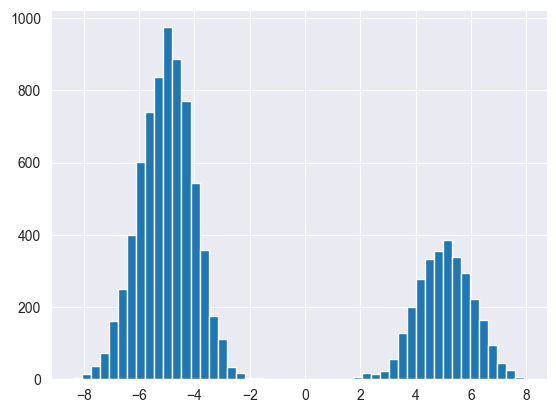

In [6]:
rng = jax.random.PRNGKey(50)

a = 5
dist = GaussianMixture(
    means=jnp.stack([-a * jnp.ones((DIST_DIM), dtype=float), a * jnp.ones((DIST_DIM), dtype=float)], axis=0),
    covs=jnp.stack([jnp.ones((DIST_DIM), dtype=float), jnp.ones((DIST_DIM), dtype=float)], axis=0)
)
#dist = D.MultivariateNormal(loc=10 * jnp.ones((DIST_DIM), dtype=float), covariance_matrix=jnp.eye((DIST_DIM), dtype=float))
log_prob = jax.jit(dist.log_prob)
grad_log_prob = jax.jit(jax.grad(dist.log_prob))

fn = jax.jit(lambda x: (x ** 2).sum(axis=-1))
true_pi = (dist.mean ** 2).sum() + jnp.trace(dist.variance)

print(f"true pi(f) = {true_pi: .3f}")

sampler = MALASampler(
    log_prob=log_prob, 
    dim=DIST_DIM, 
    n_samples=SAMPLER_N_SAMPLES, 
    gamma=8e-2, 
    burnin_steps=SAMPLER_N_BURNIN, 
    init_std=30.0
)
rng, key = jax.random.split(rng)
samples = sampler(key, n_chains=N_CHAINS).reshape(-1, DIST_DIM)

plt.hist(samples[:, 0], bins=50)
plt.show()

In [7]:
class ModelWithConstant(eqx.Module):
    model: eqx.Module
    c: jax.Array
    
    def __init__(self, model: eqx.Module, shape, key: jax.random.PRNGKey):
        self.model = model
        self.c = jax.random.normal(key, shape)
    
    @eqx.filter_jit
    def __call__(self, x):
        return self.model(x)

In [ ]:
jax.tree_util.tree_map(lambda x: hasattr(x, "ndim") and x.ndim > 1, model)

In [92]:
from diffcv.cv.nn import init_linear, xavier_uniform_init, he_uniform_init, zero_init

def train_model(
        key: jax.random.PRNGKey, 
        dist_dim: int, 
        fn: tp.Callable, 
        grad_log_prob: tp.Callable,
        train_dataloader: jdl.DataLoader, 
        eval_dataloader: jdl.DataLoader,
        lr: float=1e-3, 
        weight_decay: float=1e-4,
        loss_fn: str="diffusion", 
        optim: str="sgd",
        n_steps: int=30_000, 
        fn_mean: float | None=None, 
        patience: int=1000, 
        eval_every_n_steps: int=10_000,
        *,
        logger: Logger
    ):
    key, subkey = jax.random.split(key)
    model = CVMLP(in_size=dist_dim, depth=3, width_size=64, activation=requ, key=subkey)

    key, subkey = jax.random.split(key)
    model = init_linear(model, key, he_uniform_init, zero_init)

    scheduler = optax.exponential_decay(init_value=lr, transition_steps=20_000, decay_rate=0.9)
    if optim == "sgd":
        optimizer = optax.inject_hyperparams(optax.sgd)(learning_rate=scheduler)
    elif optim == "adam":
        optimizer = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler)
    elif optim == "adamw":
        weight_mask = lambda m: jax.tree_util.tree_map(lambda x: x.ndim > 1, m)
        optimizer = optax.inject_hyperparams(optax.adamw)(learning_rate=scheduler, weight_decay=weight_decay, mask=weight_mask)
    else:
        raise NotImplementedError(f"unknown optimizer: {optim}")

    if loss_fn == "diffusion":
        loss = DiffusionLoss(fn=fn)
    elif loss_fn == "diff":
        loss = DiffLoss(fn=fn, grad_log_prob=grad_log_prob, noise_std=1.0)
    elif loss_fn == "var":
        key, subkey = jax.random.split(key)
        model = ModelWithConstant(model, (1,), subkey)
        loss = VarLoss(fn=fn, grad_log_prob=grad_log_prob)
    else:
        raise NotImplementedError(f"unknown loss function: {loss_fn}")

    trainer = CVTrainer(
        model, 
        fn, 
        grad_log_prob, 
        train_dataloader,
        eval_dataloader,
        optimizer, 
        loss, 
        logger,
        fn_mean=fn_mean,
        n_steps=n_steps, 
        eval_every_n_steps=eval_every_n_steps,
        patience=patience,
        grad_clipping=100
    )

    key, subkey = jax.random.split(key)
    model = trainer.train(subkey)
    
    return model

def train_als_model(
        key: jax.random.PRNGKey, 
        dist_dim: int, 
        fn: tp.Callable, 
        grad_log_prob: tp.Callable,
        train_dataloader: jdl.DataLoader, 
        eval_dataloader: jdl.DataLoader,
        lr: float=1e-3, 
        weight_decay: float=1e-4,
        optim: str="adam",
        n_steps: int=30_000, 
        switch_steps: int=10_000, 
        patience: int=1000, 
        eval_every_n_steps: int=10_000,
        *,
        logger: Logger
    ):

    key, subkey = jax.random.split(key)
    model = CVMLP(in_size=dist_dim, depth=3, width_size=64, activation=requ, key=subkey)

    key, subkey = jax.random.split(key)
    model = init_linear(model, key, he_uniform_init, zero_init)

    scheduler_diffusion = optax.exponential_decay(init_value=lr, transition_steps=20_000, decay_rate=0.9)
    scheduler_stein = optax.exponential_decay(init_value=lr, transition_steps=20_000, decay_rate=0.9)

    if optim == "adam":
        optimizer_diffusion = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler_diffusion)
        optimizer_stein = optax.inject_hyperparams(optax.adam)(learning_rate=scheduler_stein)
    elif optim == "adamw":
        weight_mask = lambda m: jax.tree_util.tree_map(lambda x: x.ndim > 1, m)
        optimizer_diffusion = optax.inject_hyperparams(optax.adamw)(learning_rate=scheduler_diffusion, weight_decay=weight_decay, mask=weight_mask)
        optimizer_stein = optax.inject_hyperparams(optax.adamw)(learning_rate=scheduler_stein, weight_decay=weight_decay, mask=weight_mask)
    else:
        raise NotImplementedError(f"unknown optimizer: {optim}")

    loss_diffusion = DiffusionLoss(fn=fn, l2_alpha=0.0)
    loss_stein = DiffLoss(fn=fn, grad_log_prob=grad_log_prob, noise_std=1.0)

    trainer = CVALSTrainer(
        model, 
        fn, 
        grad_log_prob, 
        train_dataloader,
        eval_dataloader,
        optimizer_diffusion, 
        optimizer_stein,
        loss_diffusion, 
        loss_stein,
        logger=logger, 
        switch_steps=switch_steps,
        n_steps=n_steps, 
        eval_every_n_steps=eval_every_n_steps,
        patience=patience,
        grad_clipping=100
    )

    key, subkey = jax.random.split(key)
    model = trainer.train(subkey)
    
    return model

In [10]:
rng, key = jax.random.split(rng)
base_estimates = Estimator(fn, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)
print("base:", Estimator.bias(true_pi, base_estimates), Estimator.std(base_estimates))

  0%|          | 0/500 [00:00<?, ?it/s]

base: -0.050048828 2.1994426


train_dataset length: 5000
eval_dataset length: 20000


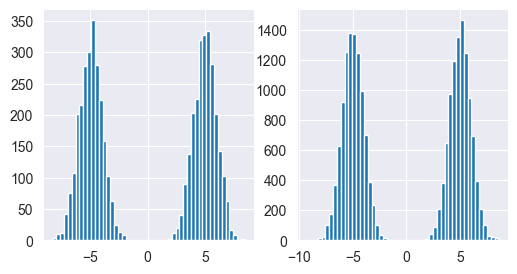

In [9]:
rng, key = jax.random.split(rng)
train_dataloader = jdl.DataLoader(
    jdl.ArrayDataset(dist.sample(key, 5000)), backend="jax", batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)
# train_dataloader = get_data_from_sampler(BATCH_SIZE, sampler, key, n_chains=TRAIN_SIZE // SAMPLER_N_SAMPLES)
print(f"train_dataset length: {len(train_dataloader.dataloader.dataset)}")

rng, key = jax.random.split(rng)
eval_dataloader = jdl.DataLoader(
    jdl.ArrayDataset(dist.sample(key, 20000)), backend="jax", batch_size=BATCH_SIZE, shuffle=True, drop_last=True
)
#eval_dataloader = get_data_from_sampler(BATCH_SIZE, sampler, key, n_chains=EVAL_SIZE // SAMPLER_N_SAMPLES)
print(f"eval_dataset length: {len(eval_dataloader.dataloader.dataset)}")

plt.figure(figsize=(6, 3))
plt.subplot(1, 2, 1)
plt.hist(train_dataloader.dataloader.dataset[:, 0], bins=50)
plt.subplot(1, 2, 2)
plt.hist(eval_dataloader.dataloader.dataset[:, 0], bins=50)
plt.show()

  0%|          | 0/20000 [00:00<?, ?it/s]

Early stopping at step 7963 due to no improvement in loss over 5000 steps.


c:\Users\kirill-korolev\mcmc-control-variates\diffcv\logger\logger.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


  0%|          | 0/500 [00:00<?, ?it/s]

diffusion: 0.03277588 0.79034555


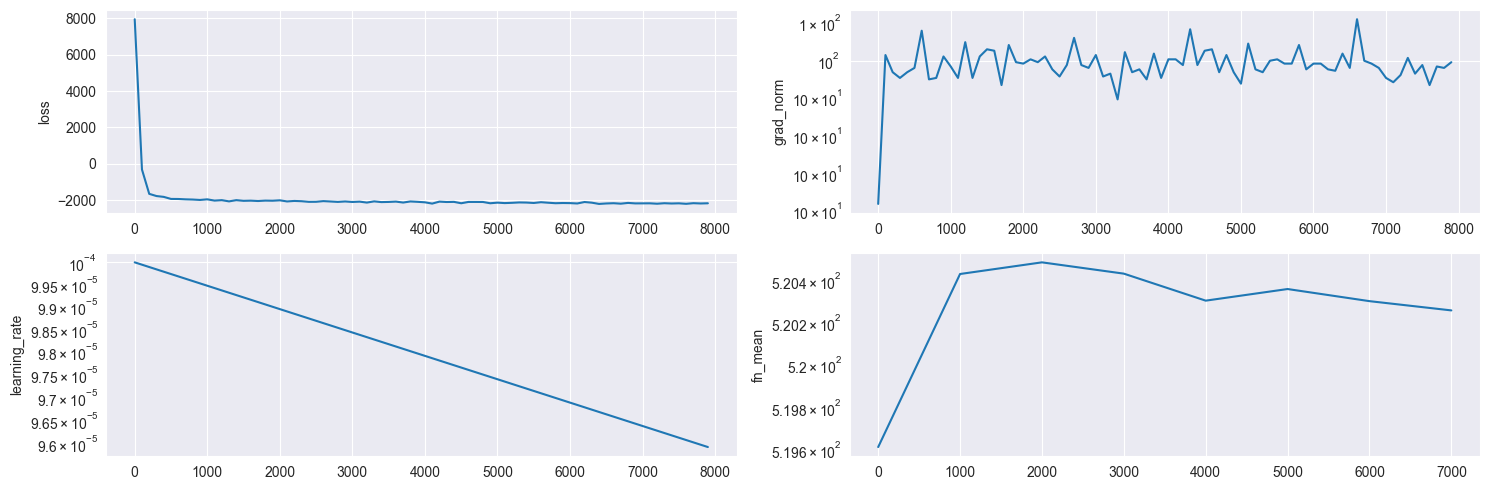

In [90]:
logger = Logger()

rng, key = jax.random.split(rng)
model_diffusion = train_model(
    key=key, 
    dist_dim=DIST_DIM, 
    fn=fn, 
    grad_log_prob=grad_log_prob, 
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    lr=1e-4, 
    weight_decay=1e-1,
    loss_fn="diffusion", 
    optim="adamw", 
    n_steps=20_000, 
    fn_mean=base_estimates.mean(),
    patience=5_000, 
    logger=logger,
    eval_every_n_steps=1_000
)

plot_log_results(logger)

generator_diffusion = ScalarGenerator(grad_log_prob, model_diffusion)
fn_with_cv = lambda x: fn(x) + generator_diffusion(x)

rng, key = jax.random.split(rng)
diffusion_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

print("diffusion:", Estimator.bias(true_pi, diffusion_estimates), Estimator.std(diffusion_estimates))

In [91]:
for layer in model_diffusion.mlp.layers:
    print("w", (layer.weight ** 2).sum(), layer.weight.shape)
    print("b", (layer.bias ** 2).sum(), layer.bias.shape)

w 21.261602 (64, 20)
b 0.20588827 (64,)
w 24.906906 (64, 64)
b 0.4914208 (64,)
w 29.18039 (64, 64)
b 1.6756288 (64,)
w 0.45098734 (1, 64)
b 0.02620225 (1,)


  0%|          | 0/30000 [00:00<?, ?it/s]

train fn_mean:  519.996
train fn_mean:  519.997
train fn_mean:  519.957


c:\Users\kirill-korolev\mcmc-control-variates\diffcv\logger\logger.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


  0%|          | 0/500 [00:00<?, ?it/s]

diffusion als: -0.054504395 0.71592814


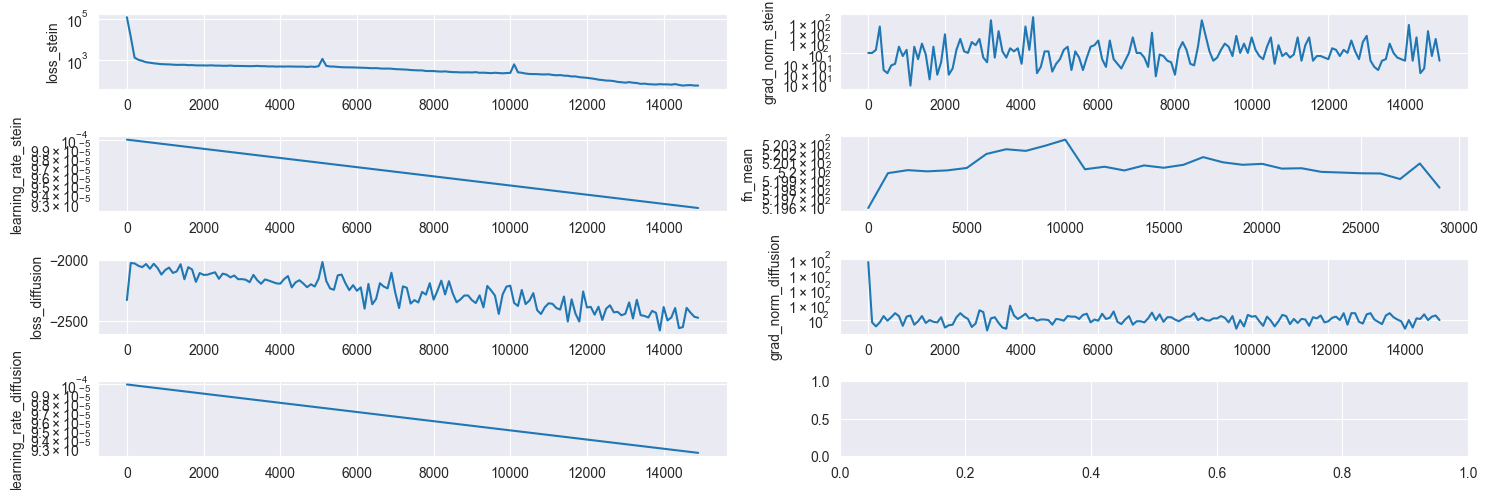

In [93]:
logger = Logger()

rng, key = jax.random.split(rng)
model_diffusion_als = train_als_model(
    key=key, 
    dist_dim=DIST_DIM, 
    fn=fn, 
    grad_log_prob=grad_log_prob, 
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    lr=1e-4,
    weight_decay=1e-1,
    optim="adamw", 
    n_steps=30_000, 
    switch_steps=5_000, 
    patience=3_000, 
    eval_every_n_steps=1_000, 
    logger=logger
)

plot_log_results(logger)

generator_diffusion_als = ScalarGenerator(grad_log_prob, model_diffusion_als)
fn_with_cv = lambda x: fn(x) + generator_diffusion_als(x)

rng, key = jax.random.split(rng)
diffusion_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

print("diffusion als:", Estimator.bias(true_pi, diffusion_estimates), Estimator.std(diffusion_estimates))

  0%|          | 0/30000 [00:00<?, ?it/s]

Early stopping at step 24116 due to no improvement in loss over 3000 steps.


c:\Users\kirill-korolev\mcmc-control-variates\diffcv\logger\logger.py:53: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


  0%|          | 0/500 [00:00<?, ?it/s]

stein diff: -0.0012207031 0.048174743


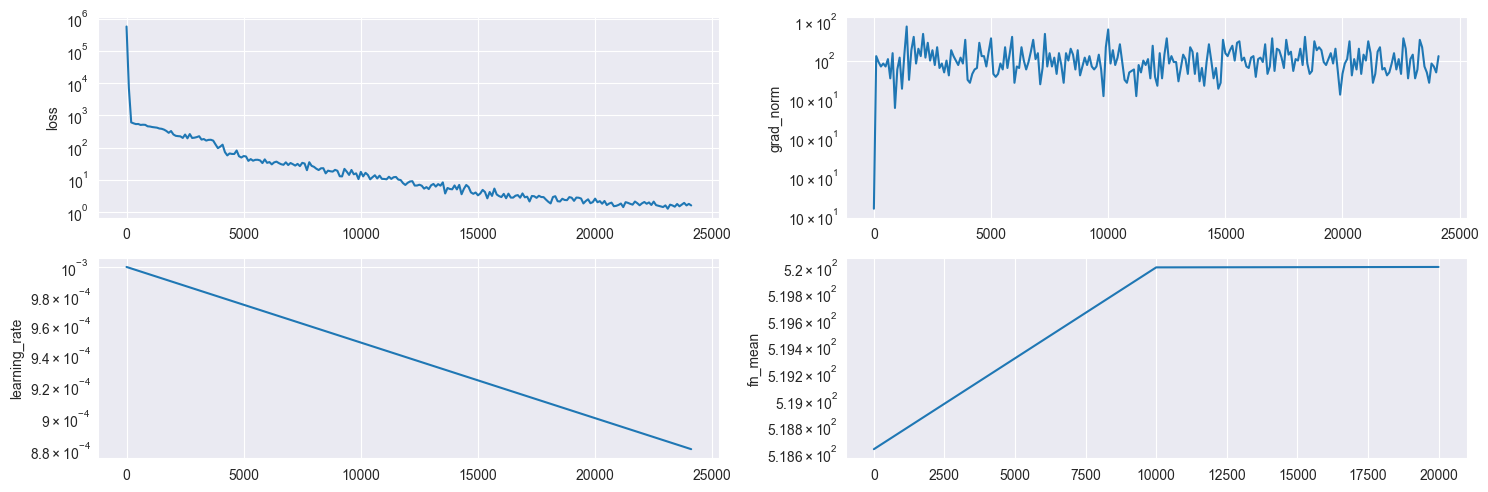

In [12]:
logger = Logger()

rng, key = jax.random.split(rng)
model_diff = train_model(
    key=key, 
    dist_dim=DIST_DIM, 
    fn=fn, 
    grad_log_prob=grad_log_prob, 
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    lr=1e-3, 
    loss_fn="diff", 
    optim="adam", 
    n_steps=30_000, 
    fn_mean=None,
    patience=3_000, 
    logger=logger
)

plot_log_results(logger)

generator_diff = ScalarGenerator(grad_log_prob, model_diff)
fn_with_cv = lambda x: fn(x) + generator_diff(x)

rng, key = jax.random.split(rng)
diffusion_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

print("stein diff:", Estimator.bias(true_pi, diffusion_estimates), Estimator.std(diffusion_estimates))

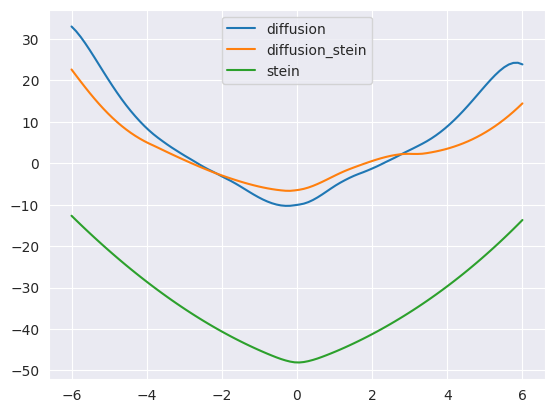

In [38]:
x = jnp.linspace(-6., 6., 100)
plt.plot(x, jax.vmap(model_diffusion)(x.reshape(-1, DIST_DIM)))
plt.plot(x, jax.vmap(model_diffusion_als)(x.reshape(-1, DIST_DIM)))
plt.plot(x, jax.vmap(model_diff)(x.reshape(-1, DIST_DIM)))
plt.legend(["diffusion", "diffusion_stein", "stein"])

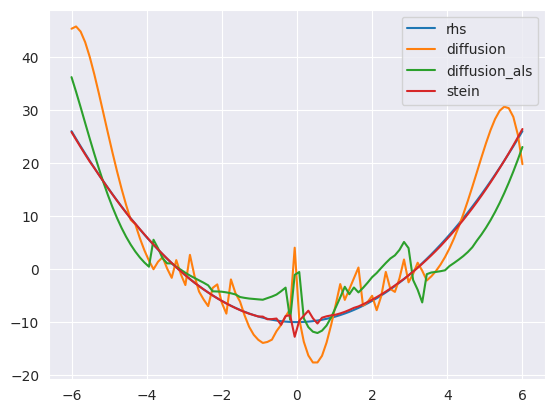

In [31]:
x = jnp.linspace(-6., 6., 100)
rhs = lambda x: x ** 2 - 1 - a ** 2
plt.plot(x, rhs(x.reshape(-1, DIST_DIM)))
plt.plot(x, -jax.vmap(generator_diffusion)(x.reshape(-1, DIST_DIM)))
plt.plot(x, -jax.vmap(generator_diffusion_als)(x.reshape(-1, DIST_DIM)))
plt.plot(x, -jax.vmap(generator_diff)(x.reshape(-1, DIST_DIM)))
plt.legend(["rhs", "diffusion", "diffusion_als", "stein"])

  0%|          | 0/30000 [00:00<?, ?it/s]

learned constant: [9.995203]


  0%|          | 0/100 [00:00<?, ?it/s]

var min: -0.00031089783 0.0047482285


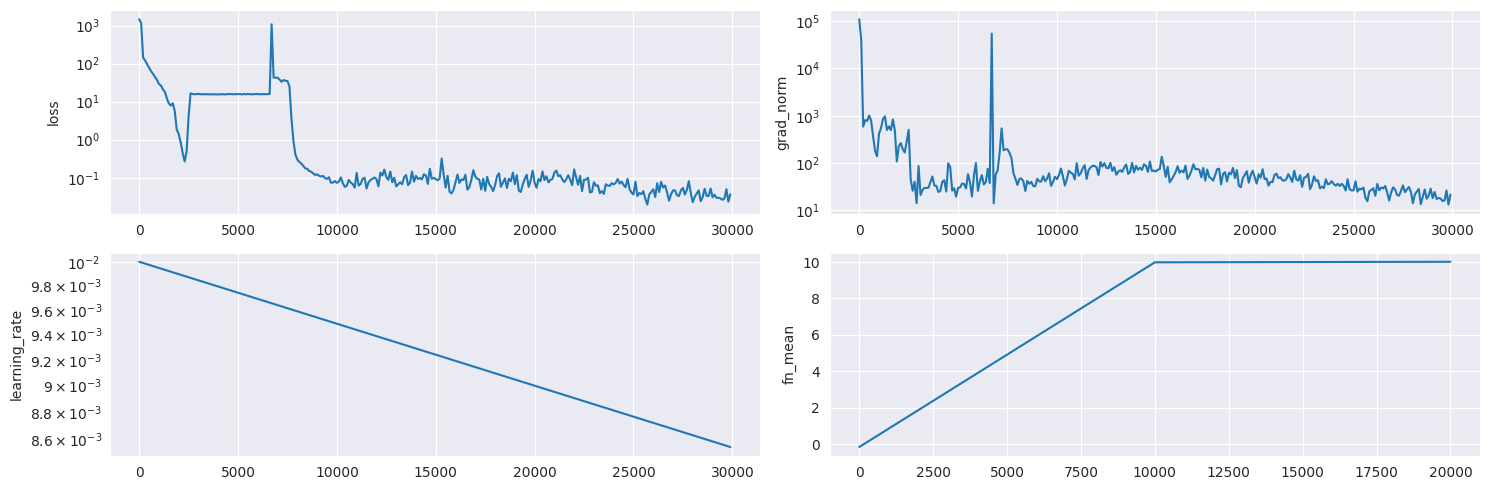

In [40]:
logger = Logger()

rng, key = jax.random.split(rng)
model_var = train_model(
    key=key, 
    dist_dim=DIST_DIM, 
    fn=fn, 
    grad_log_prob=grad_log_prob, 
    train_dataloader=train_dataloader,
    eval_dataloader=eval_dataloader,
    lr=1e-2, 
    loss_fn="var", 
    optim="adam", 
    n_steps=30_000, 
    fn_mean=None,
    patience=10_000, 
    logger=logger
)

print(f"learned constant: {model_var.c}")
model_var = model_var.model

plot_log_results(logger)

generator_var = ScalarGenerator(grad_log_prob, model_var)
fn_with_cv = lambda x: fn(x) + generator_var(x)

rng, key = jax.random.split(rng)
diffusion_estimates = Estimator(fn_with_cv, sampler)(key, n_chains=N_CHAINS, n_estimates=MCMC_N_ESTIMATES)

print("var min:", Estimator.bias(true_pi, diffusion_estimates), Estimator.std(diffusion_estimates))

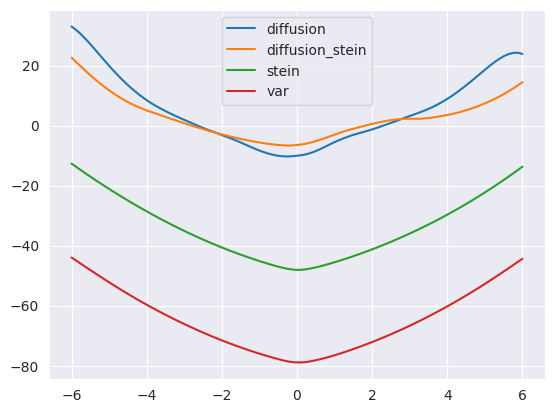

In [42]:
x = jnp.linspace(-6., 6., 100)
plt.plot(x, jax.vmap(model_diffusion)(x.reshape(-1, DIST_DIM)))
plt.plot(x, jax.vmap(model_diffusion_als)(x.reshape(-1, DIST_DIM)))
plt.plot(x, jax.vmap(model_diff)(x.reshape(-1, DIST_DIM)))
plt.plot(x, jax.vmap(model_var)(x.reshape(-1, DIST_DIM)))
plt.legend(["diffusion", "diffusion_stein", "stein", "var"])

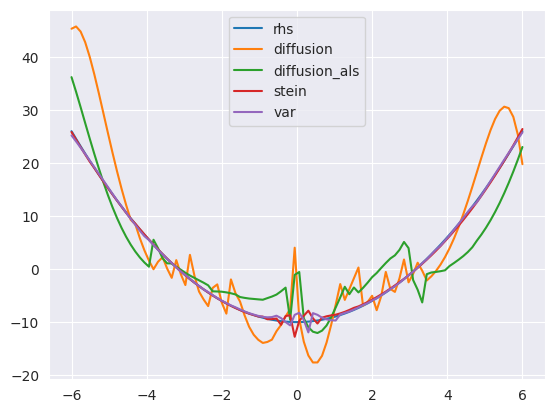

In [41]:
x = jnp.linspace(-6., 6., 100)
rhs = lambda x: x ** 2 - 1 - a ** 2
plt.plot(x, rhs(x.reshape(-1, DIST_DIM)))
plt.plot(x, -jax.vmap(generator_diffusion)(x.reshape(-1, DIST_DIM)))
plt.plot(x, -jax.vmap(generator_diffusion_als)(x.reshape(-1, DIST_DIM)))
plt.plot(x, -jax.vmap(generator_diff)(x.reshape(-1, DIST_DIM)))
plt.plot(x, -jax.vmap(generator_var)(x.reshape(-1, DIST_DIM)))
plt.legend(["rhs", "diffusion", "diffusion_als", "stein", "var"])

In [ ]:
def diff_run(dist_dim: int):
    rng = jax.random.PRNGKey(50)

    dist = D.MultivariateNormal(loc=10 * jnp.ones((dist_dim), dtype=float), covariance_matrix=jnp.eye((dist_dim), dtype=float))
    log_prob = jax.jit(dist.log_prob)
    grad_log_prob = jax.jit(jax.grad(dist.log_prob))

    fn = jax.jit(lambda x: (x ** 2).sum(axis=-1))
    true_pi = (dist.mean ** 2).sum() + dist.variance.sum()

    sampler = MALASampler(
        log_prob=log_prob, 
        dim=dist_dim, 
        n_samples=SAMPLER_N_SAMPLES, 
        gamma=5e-2, 
        burnin_steps=SAMPLER_N_BURNIN, 
        init_std=3.0
    )

    train_size = 900 + 10 * dist_dim
    eval_size = 20_000

    rng, key = jax.random.split(rng)
    train_dataloader = get_data_from_sampler(BATCH_SIZE, sampler, key, n_chains=train_size // SAMPLER_N_SAMPLES)
    print(f"train_dataset length: {len(train_dataloader.dataloader.dataset)}")

    rng, key = jax.random.split(rng)
    eval_dataloader = get_data_from_sampler(BATCH_SIZE, sampler, key, n_chains=eval_size // SAMPLER_N_SAMPLES)
    print(f"eval_dataset length: {len(eval_dataloader.dataloader.dataset)}")

    logger = Logger()

    rng, key = jax.random.split(rng)
    model = train_model(
        key=key, 
        dist_dim=dist_dim, 
        fn=fn, 
        grad_log_prob=grad_log_prob, 
        train_dataloader=train_dataloader,
        eval_dataloader=eval_dataloader,
        lr=1e-3, 
        loss_fn="diff", 
        optim="adam", 
        n_steps=40_000 + 100 * dist_dim,
        fn_mean=None,
        patience=20_000, 
        logger=logger
    )

    plot_log_results(logger)

    generator = ScalarGenerator(grad_log_prob, model)
    fn_with_cv = lambda x: fn(x) + generator(x)

    rng, key = jax.random.split(rng)
    estimates = Estimator(fn_with_cv, sampler)(key, n_chains=10, n_estimates=100)
    
    bias, std = Estimator.bias(true_pi, estimates), Estimator.std(estimates)
    print(dist_dim, bias, std)
    return bias, std

In [ ]:
from collections import defaultdict

In [ ]:
results = defaultdict(list)

train_dataset length: 10000
eval_dataset length: 20000


  0%|          | 0/140000 [00:00<?, ?it/s]

Early stopping at step 67221 due to no improvement in loss over 20000 steps.


  0%|          | 0/100 [00:00<?, ?it/s]

1000 5.25 43.34301


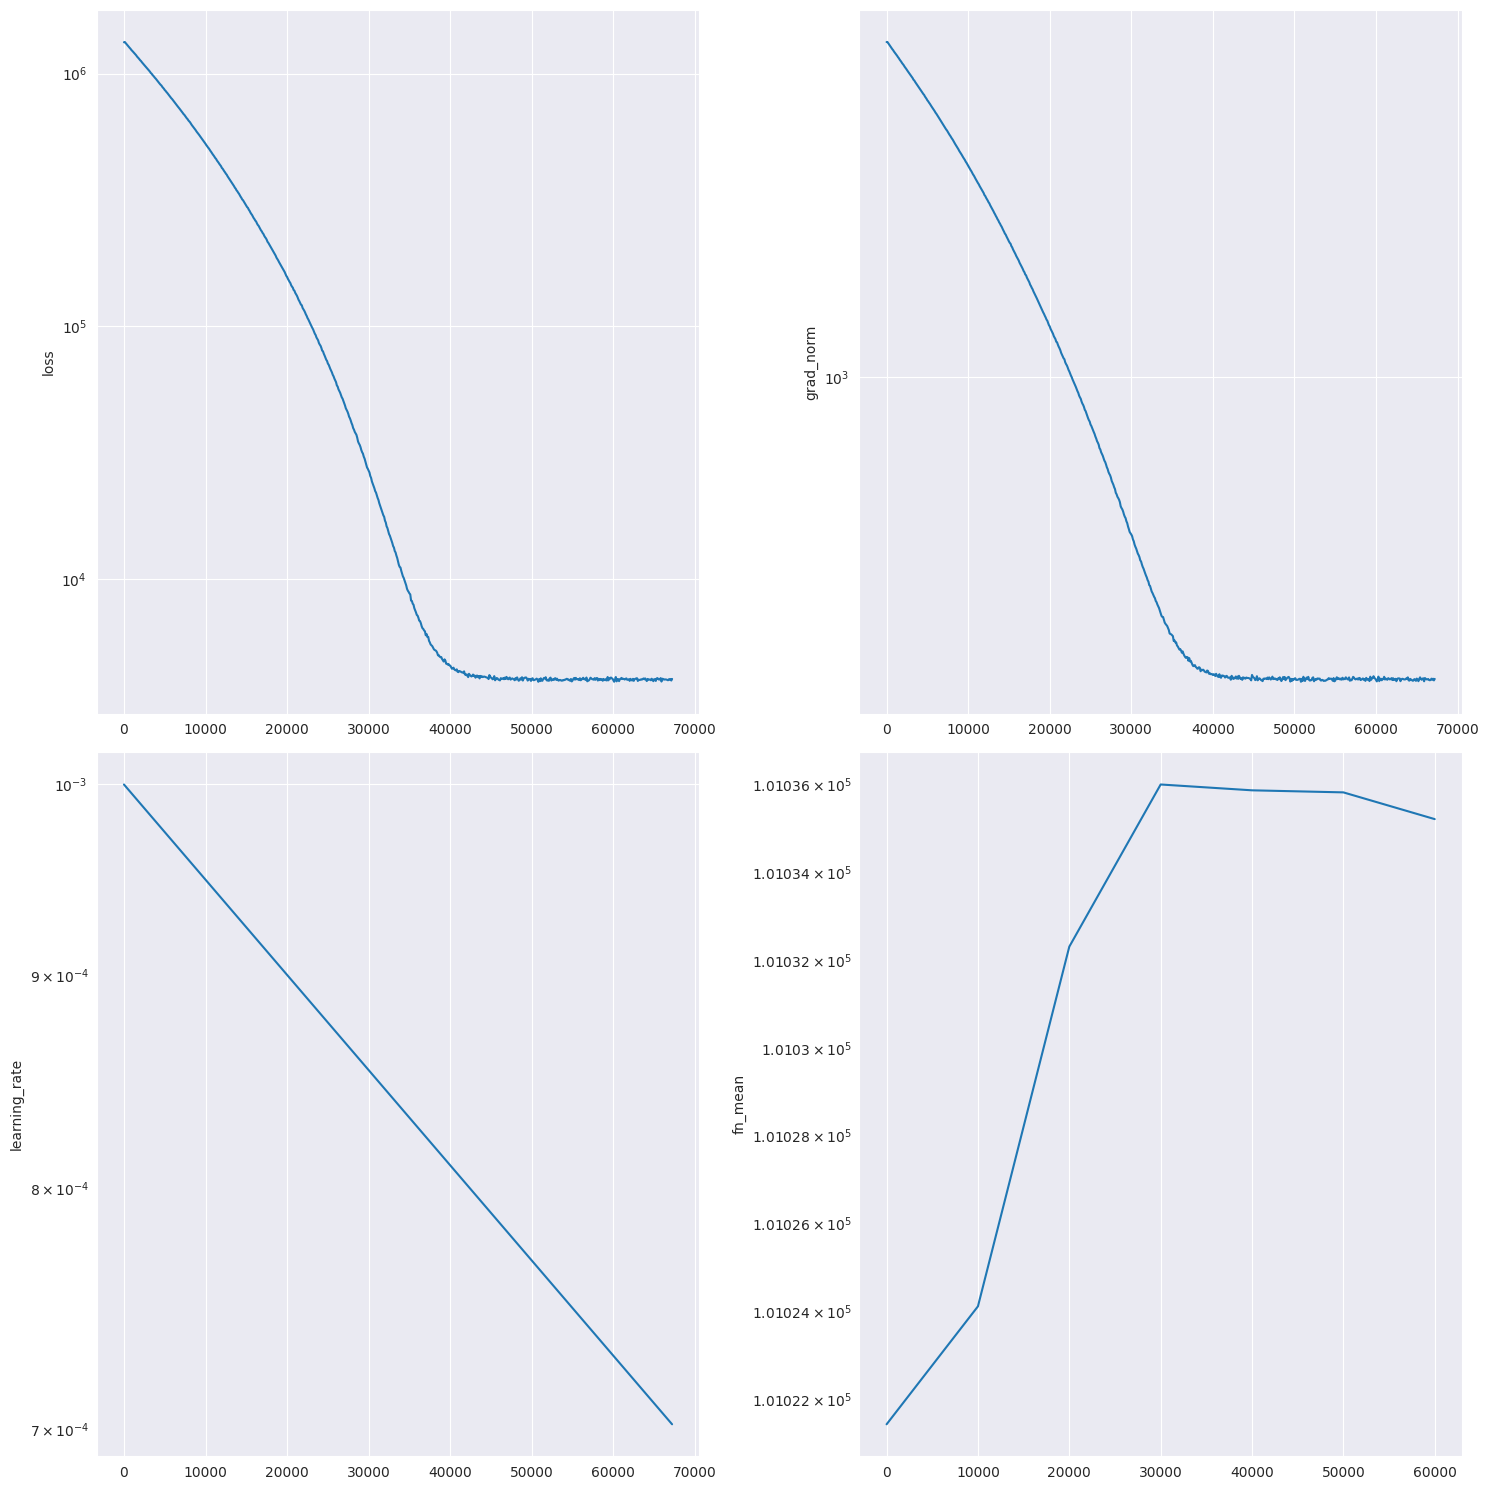

In [ ]:
for dist_dim in [1000]:
    bias, std = diff_run(dist_dim)
    results["diff"] = {
        "bias": bias,
        "std": std,
        "dim": dist_dim
    }

In [ ]:
t1000 = results["diff"]

In [ ]:
results["diff"]

[{'bias': Array(5.25, dtype=float32),
  'std': Array(43.34301, dtype=float32),
  'dim': 1000},
 {'bias': -6.1035156e-05, 'std': 0.08799228, 'dim': 10},
 {'bias': 0.025390625, 'std': 1.442239, 'dim': 100}]

In [ ]:
a = 3
dist = D.Mixture(mixing_distribution=D.Categorical(jnp.asarray([0.5, 0.5])), component_distributions=[D.Normal(loc=-a, scale=1), D.Normal(loc=a, scale=1)])

2024-08-14 15:00:11.737491: W external/xla/xla/service/gpu/nvptx_compiler.cc:836] The NVIDIA driver's CUDA version is 12.2 which is older than the PTX compiler version (12.6.20). Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [ ]:
grad_log_prob = jax.grad(dist.log_prob)

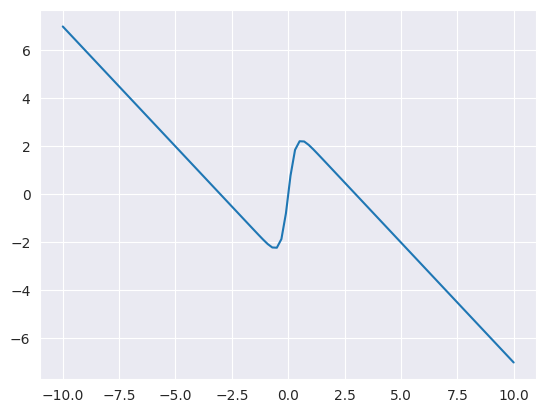

In [ ]:
x = np.linspace(-10, 10, 100)
y = jax.vmap(grad_log_prob)(x)
plt.plot(x, y)

$$
p_1(x) = \mathcal{N}(-a, 1), p_2(x) = \mathcal{N}(a, 1)
\\
p(x) = 0.5 p_1(x) + 0.5 p_2(x)
\\
\\
(\log p(x))' y'(x) + y''(x) = x^2 - 1 - a^2
\\
y'(x) = u(x)
\\
u(x) = \frac{C(x)}{p(x)}
\\
C(x) = \int_{-\infty}^{x} (t^2 - 1 - a^2) p(t) dt
\\
y(x) = \int_{-\infty}^{x} \frac{C(t)}{p(t)} dt + C
$$

In [ ]:
from scipy.integrate import quad

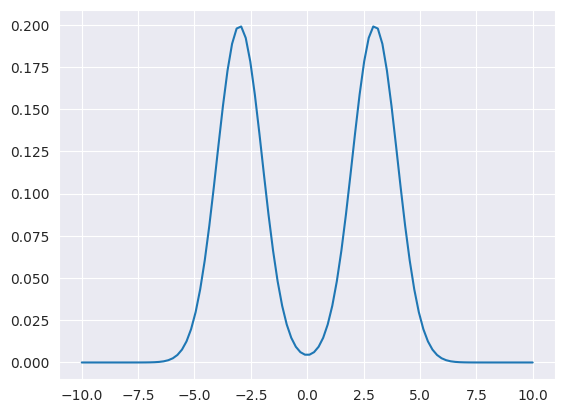

In [ ]:
def get_normal_density(loc, scale=1):
    def density(x):
        return 1 / (np.sqrt(2*np.pi) * scale) * np.exp(-0.5 / (scale * scale) * ((x - loc) ** 2))
    return density

def get_mixture_density(coeffs, locs, scales):
    ps = [get_normal_density(loc, scale) for loc, scale in zip(locs, scales)]
    def density(x):
        ans = 0.0
        for c, p in zip(coeffs, ps):
            ans += c * p(x)
        return ans
    return density

p_mixture = get_mixture_density([0.5, 0.5], [-3, 3], [1, 1])
plt.plot(x, p_mixture(x))

In [ ]:
def C(x):
    return (x**2 - 1 - a**2) * p_mixture(x)

def get_u(C_int):
    def u(x):
        return C_int

ts = np.linspace(-1000, 1000, 1000)
C_int = [quad(C, -np.inf, t)[0] for t in ts]